In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.special import hyp2f1
from density import density
from calculate_rp import interpolate, get_sr
import pandas as pd

In [2]:
#h = 10300

g = 9.8065
L0 = 24.06031 * g

wp = 0.229158

rp_max = 6.122831
l = 2 * hyp2f1(1/4, 1/2, 5/4, 1) * rp_max
ds = 0.002

In [3]:
def b(h):
    ro_atm = density(h)[0]
    ro_gas = density(h)[1]
    b = (ro_atm - ro_gas) * g 
    return b

In [4]:
from scipy.interpolate import interp1d
rs, s_half = get_sr(rp_max)
f = interp1d(s_half, rs, kind='cubic')

In [5]:
from scipy.integrate import solve_ivp


def Solve(theta0, a, h):  
    def func(t, y):
        if t <= l / 2:
            rp = f(t)
        else:
            rp = f(l - t)   
        theta, T, z, r = y
        p = b(h) * (z - a)
        sin = np.sin(theta)
        cos = np.cos(theta)
        return [
            - 2 * np.pi * (rp * wp * sin + p * r) / T,
            2 * np.pi * rp * wp * cos,
            cos,
            sin
        ]

    T0 = L0 / np.cos(theta0)
    z0, r0 = 0, 0

    sol = solve_ivp(func, t_span=[0, l], y0=[theta0, T0, z0, r0], t_eval=np.arange(0, l, ds))
    
    return sol.y, sol.t

In [11]:
np.degrees(Solve(np.radians(5), 4.7, 20300)[0])

array([[ 5.00000000e+00,  5.00000083e+00,  5.00000332e+00, ...,
        -1.08172990e+01, -1.08105781e+01, -1.08038494e+01],
       [ 1.35704315e+04,  1.35704317e+04,  1.35704322e+04, ...,
         1.83959443e+04,  1.83959449e+04,  1.83959451e+04],
       [ 0.00000000e+00,  1.14155503e-01,  2.28311007e-01, ...,
         9.11019028e+02,  9.11131584e+02,  9.11244143e+02],
       [ 0.00000000e+00,  9.98731299e-03,  1.99746293e-02, ...,
        -2.13951338e+01, -2.14166335e+01, -2.14381200e+01]])

In [6]:
def GridSearch(h, theta_max):
    optimal_z, optimal_r, theta0, loss_min = [], [], 90, 100
    for i in np.arange(np.radians(theta_max), np.radians(0), - np.radians(0.1)):
        for j in np.arange(0, 10, 0.5):
            theta, T, z, r = Solve(i, j, h)[0]
            if  -91 < np.degrees(theta[-1]) < -89 and -0.1 < r[-1] < 0.1:
                loss = np.sqrt((- np.pi / 2 - theta[-1])**2 + r[-1]**2) 
                print(loss)
                if loss < loss_min:
                    loss_min = loss
                    optimal_z = z
                    optimal_r = r
                    theta0 = np.degrees(i)
    return [optimal_z, optimal_r, theta0, loss_min]

In [7]:
theta_max = 90

In [9]:
GridSearch(19000, theta_max)

0.0897335499429585
0.0816018153140503
0.054894677517789994
0.030877716962183
0.02073874176591273


[array([0.00000000e+00, 1.83132516e-03, 3.66265020e-03, ...,
        1.18356502e+01, 1.18356912e+01, 1.18357323e+01]),
 array([0.        , 0.0008039 , 0.00160779, ..., 0.00693756, 0.00493799,
        0.00293842]),
 23.700000000004124,
 0.02073874176591273]

In [10]:
GridSearch(17000, theta_max)

0.06898340013161804
0.05127266360282962


[array([0.00000000e+00, 1.95844561e-03, 3.91689116e-03, ...,
        1.26163204e+01, 1.26164116e+01, 1.26165027e+01]),
 array([0.        , 0.00040557, 0.00081115, ..., 0.02744946, 0.02545154,
        0.02345362]),
 11.70000000000487,
 0.05127266360282962]

In [12]:
GridSearch(21500, 80)

0.07301423507305672
0.04125154232968861
0.015616560106982293
0.009418879671832352


[array([0.00000000e+00, 1.21475168e-03, 2.42950335e-03, ...,
        1.01236409e+01, 1.01236521e+01, 1.01236633e+01]),
 array([ 0.        ,  0.00158883,  0.00317766, ..., -0.00356972,
        -0.00556971, -0.00756968]),
 52.6000000000017,
 0.009418879671832352]

In [13]:
GridSearch(21500, 80)

0.07301423507305672
0.04125154232968861
0.015616560106982293
0.009418879671832352


[array([0.00000000e+00, 1.21475168e-03, 2.42950335e-03, ...,
        1.01236409e+01, 1.01236521e+01, 1.01236633e+01]),
 array([ 0.        ,  0.00158883,  0.00317766, ..., -0.00356972,
        -0.00556971, -0.00756968]),
 52.6000000000017,
 0.009418879671832352]

90
Height:  20000 Loss:  0.03358055804226683


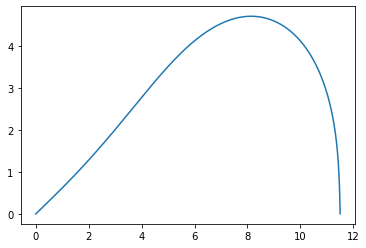

293.9616947174072


In [23]:
import time
start=time.time()
for h in range(20000, 19000, -1000):
    print(theta_max)
    z, r, theta_max, loss = GridSearch(h, theta_max)
    print("Height: ", h, "Loss: ", loss)
    plt.plot(z, r)
    plt.show()
stop = time.time()

print(stop-start)

In [19]:
np.degrees(0.03358055804239346)

1.9240242495232391

In [10]:
def theta(h):
    optimal_z, optimal_r, theta0, loss_min = [], [], 90, 100
    for i in np.arange(np.radians(0), np.radians(theta_max), np.radians(0.1)): 
        for j in np.arange(0, 10, 0.5):
            theta, T, z, r = Solve(i, j, h)[0]
            loss = np.sqrt((- np.pi / 2 - theta[-1])**2 + r[-1]**2)
            if loss < loss_min:
                loss_min = loss
                optimal_theta = np.degrees(theta[-1])
                a = j
                theta0 = np.degrees(i)
                
    return [optimal_theta, a, loss_min, theta0]

In [11]:
theta(2000)

[-85.79824820377631, 4.5, 0.0748088692773435, 3.5]

In [19]:
theta(20000)

[-88.09592184911546, 4.0, 0.03358055804239346, 31.4]

In [26]:
theta_arr = []
a_arr = []
for h in range(24000, 16000, -500):
    thet, a, loss, theta0 = theta(h)
    theta_arr.append(thet)
    a_arr.append(a)
    print("Height: ", h, "Last theta: ", thet, "a: ", a, "theta0: ", theta0, "total loss: ", loss) 

Height:  24000 Last theta:  -70.29239148543151 a:  0.0 theta0:  46.0 total loss:  0.35176400300534827
Height:  23500 Last theta:  -74.58653164391639 a:  0.0 theta0:  48.1 total loss:  0.27401127858037744
Height:  23000 Last theta:  -78.65181108242928 a:  0.0 theta0:  50.0 total loss:  0.19964825915251933
Height:  22500 Last theta:  -82.92635419556821 a:  0.0 theta0:  51.900000000000006 total loss:  0.12616313835849727
Height:  22000 Last theta:  -86.96447214174688 a:  0.0 theta0:  53.7 total loss:  0.053085524254001856
Height:  21500 Last theta:  -89.67886109578505 a:  0.5 theta0:  52.6 total loss:  0.009418879672808663
Height:  21000 Last theta:  -90.1129598391547 a:  2.0 theta0:  45.2 total loss:  0.0019767580269537868
Height:  20500 Last theta:  -90.1961927499471 a:  3.0 theta0:  38.900000000000006 total loss:  0.00348886440386276
Height:  20000 Last theta:  -88.09592184911546 a:  4.0 theta0:  31.4 total loss:  0.03358055804239346
Height:  19500 Last theta:  -88.75955950262457 a:  4

14:52 - start
14:54 - 24
14:56 - 23.5
14:59 - 23
15:01 - 22.5
15:04 - 22
15:05 - 21.5
15:08 - 21
15:13 - 20
15:16 - 19
15:23 - 18
15:27 - 17
15:30 - 16.5 end

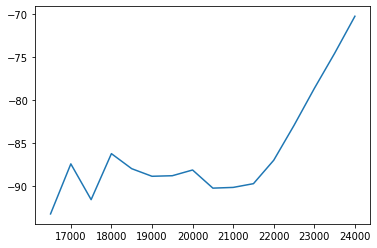

In [28]:
h = range(24000, 16000, -500)
plt.plot(h, theta_arr)

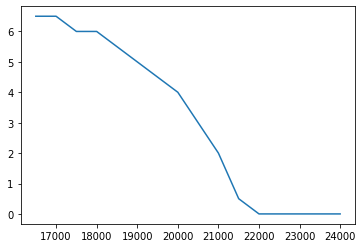

In [29]:
plt.plot(h, a_arr)

In [30]:
theta0_arr = [46.0, 48.1, 50.0, 51.9, 53.7, 52.6, 45.2, 38.9, 31.4, 27.6, 23.7, 19.5, 15.7, 15.5, 11.7, 11.4]

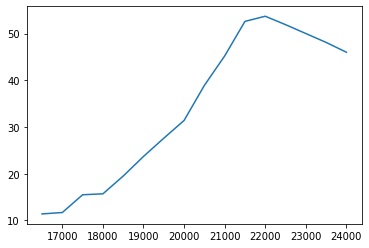

In [31]:
plt.plot(h, theta0_arr)

In [ ]:
for h in range(24000, 21500, -500):
    thet, a, loss, theta0 = theta(h)
    theta_arr.append(thet)
    a_arr.append(a)
    print("Height: ", h, "Last theta: ", thet, "a: ", a, "theta0: ", theta0, "total loss: ", loss) 

In [ ]:
7
